In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.io import loadmat
from mpl_toolkits.mplot3d import axes3d
import pickle
import os

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



# Formulation of the Problem
Our goal is to estimate $\frac{\lambda+\mu}{\mu}$ of the vector wave equation, given the dataset of $u$ and $w$. The formulation can be written as follows:

\begin{align}
\frac{\partial^2 u}{\partial\tau^2} = \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) + \left(\frac{\lambda+\mu}{\mu}\right)\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 w}{\partial x \partial y}\right)\\
\frac{\partial^2 w}{\partial\tau^2} = \left(\frac{\partial^2 w}{\partial x^2} + \frac{\partial^2 w}{\partial y^2}\right) + \left(\frac{\lambda+\mu}{\mu}\right)\left(\frac{\partial^2 u}{\partial x \partial y} + \frac{\partial^2 w}{\partial y^2}\right)
    \end{align}

The true value of $\frac{\lambda+\mu}{\mu}$ is $\frac{50+30}{30} = 2.667$.

In [2]:
# Import .mat file
data = loadmat('./../Dataset/vector_2nd.mat')
u = data['u_log'].transpose(1, 0, 2)
w = data['v_log'].transpose(1, 0, 2)
tspan = data['tspan']

- **Grid Creation:**
  - `x = np.arange(0, 1.01, 0.01)` and `y = np.arange(0, 1.01, 0.01)` generate equidistant spatial points from 0 to 1 (step 0.01).
  - `t = tspan.reshape(-1)` creates a 1D array of time points (assumed equidistant over the given span).

- **Index Selection:**
  - `x_indices` and `y_indices` select every 10th point in `x` and `y` (using `np.arange(0, len(x), 10)`).
  - `t_indices` includes every time step (using `np.arange(0, len(t), 1)`).

- **Meshgrid and Data Assembly:**
  - A meshgrid is created with `x[x_indices]`, `y[y_indices]`, and `t[t_indices]` to form spatial-temporal grids: `xv`, `yv`, `tv`.
  - `xyt_train` is built by reshaping and horizontally stacking the meshgrid arrays into a list of (x, y, t) points.

- **Extracting Training Data:**
  - `u_train` and `w_train` are extracted from the full `u` and `w` arrays using advanced indexing with the selected indices, then reshaped into column vectors.

- **Boundary Condition Observations:**
  - `observe_u` and `observe_w` are defined as point-set boundary conditions using `dde.icbc.PointSetBC` for components 0 and 1, respectively.

In [3]:
x = np.arange(0, 1.01, 0.01)  # Equidistant spacing from 0 to 1 with step size 0.01
y = np.arange(0, 1.01, 0.01)  # Equidistant spacing from 0 to 1 with step size 0.01
t = tspan.reshape(-1)  # Equidistant spacing from 0 to 0.001 with step size 0.0001

# Get indices of every 10 points in space and every time step
x_indices = np.arange(0, len(x), 10)
y_indices = np.arange(0, len(y), 10)
t_indices = np.arange(0, len(t), 1)

# Create meshgrid using every 10 points in space and every time step
xv, yv, tv = np.meshgrid(x[x_indices], y[y_indices], t[t_indices])
xyt_train = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1), tv.reshape(-1,1)))

u_train = u[x_indices[:, None, None], y_indices[None, :, None], t_indices[None, None, :]].reshape(-1,1)
w_train = w[x_indices[:, None, None], y_indices[None, :, None], t_indices[None, None, :]].reshape(-1,1)

print(xyt_train.shape, u_train.shape)

observe_u = dde.icbc.PointSetBC(xyt_train, u_train, component=0)
observe_w = dde.icbc.PointSetBC(xyt_train, w_train, component=1)

(12221, 3) (12221, 1)


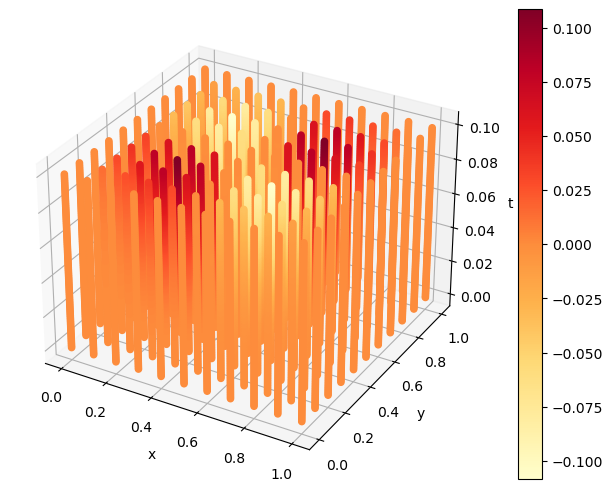

In [4]:
plt.rcParams["figure.figsize"] = [8.00, 5]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(xv, yv, tv, c= w_train , cmap='YlOrRd', alpha=1)
fig.colorbar(img)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()

- **Parameter Specification:**
  - `lamb = 50` and `mu = 30` set the values for the parameters lambda and mu.
  - `Ctrue = (lamb+mu)/mu` computes the true value of C as the ratio of (lambda + mu) to mu.
  - The computed `Ctrue` is printed to the console.

- **Initial Guess for C:**
  - `C = dde.Variable(2.0)` defines an initial guess for the parameter C as a trainable variable with an initial value of 2.0.

In [7]:
# Specify parameters lambda, mu
lamb = 50
mu = 30
Ctrue = (lamb+mu)/mu
print(Ctrue)

# Define initial guess for C
C = dde.Variable(2.0)

2.6666666666666665


**Function: `pde(x, y)`**
- Defines the PDE loss by computing second derivatives (Hessians) for two outputs:
  - For `u` (component 0): computes `du_xx`, `du_yy`, `du_xy`, and `du_tt`.
  - For `w` (component 1): computes `dw_xx`, `dw_yy`, `dw_xy`, and `dw_tt`.
- Returns two residuals:
  - Residual for `u`: `- du_tt + (du_xx + du_yy) + C*(du_xx + dw_xy)`
  - Residual for `w`: `- dw_tt + (dw_xx + dw_yy) + C*(dw_yy + du_xy)`

**Function: `get_initial_loss(model)`**
- Compiles the model and runs a 0-iteration training to obtain the initial loss.
- Returns the first training loss value from `losshistory`.

In [9]:
def pde(x, y):
    '''Define a system of PDE to be used as loss function
      Input  x: input neurons representing (x, y, t)
              y: output from neuron network (u, w)

      Return a list of equations to be used in loss function'''

    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    du_xy = dde.grad.hessian(y, x, component=0, i=0, j=1)
    du_tt = dde.grad.hessian(y, x, component=0, i=2, j=2)

    dw_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dw_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    dw_xy = dde.grad.hessian(y, x, component=1, i=0, j=1)
    dw_tt = dde.grad.hessian(y, x, component=1, i=2, j=2)

    return [- du_tt + (du_xx + du_yy) + C*(du_xx + dw_xy),
            - dw_tt + (dw_xx + dw_yy) + C*(dw_yy + du_xy)]

def get_initial_loss(model):
    # get loss of the first iteration to weight the loss function
    model.compile("adam", lr=0.001)
    losshistory, train_state = model.train(0)
    return losshistory.loss_train[0]

# Neural Network Setup and Train Model

- **Domain Setup:**
  - **Spatial Domain:** `[0, 1] × [0, 1]` defined with `dde.geometry.Rectangle`.
  - **Time Domain:** `[0, 0.1]` defined with `dde.geometry.TimeDomain` (comment suggests `[0, 0.001]`).
  - **Spatio-Temporal Domain:** Combined using `dde.geometry.GeometryXTime`.

- **Data Preparation:**
  - Creates PDE data with `dde.data.TimePDE` using:
    - The combined domain (`geomtime`)
    - PDE function (`pde`)
    - Observations `[observe_u, observe_w]`
    - 700 domain points, 10,000 test points, and anchors (`xyt_train`).

- **Neural Network Setup:**
  - **Architecture:** `layer_size = [3] + [100]*3 + [2]` (3 inputs, 3 hidden layers of 100 neurons, 2 outputs).
  - **Activation & Initializer:** `"tanh"` and `"Glorot uniform"`.
  - **Network Creation:** Built with `dde.nn.STMsFFN` (with `sigmas_x=[1, 5]`, `sigmas_t=[1, 5]`) and a feature transform is applied.

- **Model Configuration:**
  - Model is assembled via `dde.Model(data, net)`.
  - Initial loss is computed to set `loss_weights = 5 / initial_losses`.
  - Compiled with the Adam optimizer (`lr=0.001`), inverse time decay, and an external trainable variable `[C]`.

- **Callbacks and Training:**
  - **Checkpoint:** Saves the model every 50 iterations.
  - **PDE Residual Resampler:** Resamples PDE and BC points every iteration (period=1).
  - **Variable Callback:** Logs the value of `C` every 100 iterations.
  - Trains for 5000 iterations (displaying every 500 iterations); a comment notes that 200,000 iterations may be needed for accurate prediction.

- **Post-Training:**
  - Saves and plots the training history and state using `dde.saveplot` in the specified output directory.

In [10]:
# Spatial domain: X × Y = [0, 1] × [0, 1]
Lx_min, Lx_max = 0.0, 1.0
Ly_min, Ly_max = 0.0, 1.0
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

# Time domain: T = [0, 0.001]
time_domain = dde.geometry.TimeDomain(0.0, 0.1)

# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_u, observe_w],
    num_domain=700,
    num_test=10000,
    anchors=xyt_train,
)

layer_size = [3] + [100] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.STMsFFN(
    layer_size, activation, initializer, sigmas_x=[1, 5], sigmas_t=[1, 5]
)
net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))

model = dde.Model(data, net)
initial_losses = get_initial_loss(model)
loss_weights = 5 / initial_losses

model.compile(
    "adam",
    lr=0.001,
    loss_weights=loss_weights,
    decay=("inverse time", 2000, 0.9),
    external_trainable_variables=[C],
)

path = "./../output/inverse_vector_wave/model"
os.makedirs(path, exist_ok=True)
checkpoint_path = os.path.join(path, "model.ckpt")
checker = dde.callbacks.ModelCheckpoint(
      checkpoint_path, save_better_only=True, period=50
  )

pde_residual_resampler = dde.callbacks.PDEPointResampler(period=1, pde_points=True, bc_points=True)

fnamevar = "./../output/inverse_vector_wave/variables.dat"
variable = dde.callbacks.VariableValue([C], period=100, filename=fnamevar)

losshistory, train_state = model.train(
    iterations=5000, callbacks=[pde_residual_resampler, variable, checker], display_every=500
) # to obtain accurate prediction, number of iterations should be 200000

dde.saveplot(losshistory, train_state, issave=True, isplot=True, output_dir="./../output/inverse_vector_wave/")

Compiling model...
Building Spatio-temporal Multi-scale Fourier Feature Network...
'compile' took 11.478255 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.63e+05, 1.77e+05, 7.96e-02, 7.20e-02]    [2.31e+05, 2.06e+05, 7.96e-02, 7.20e-02]    []  

Best model at step 0:
  train loss: 4.40e+05
  test loss: 4.37e+05
  test metric: []

'train' took 7.601663 s

Compiling model...
'compile' took 8.040955 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.54e+00, 4.58e+00, 6.20e+00, 4.15e+00]    [3.07e+00, 4.17e+00, 6.20e+00, 4.15e+00]    []  


Exception ignored in: <function _xla_gc_callback at 0x000001D7FE12D120>
Traceback (most recent call last):
  File "c:\Users\napat\anaconda3\envs\new_env\lib\site-packages\jax\_src\lib\__init__.py", line 99, in _xla_gc_callback
KeyboardInterrupt: 


KeyboardInterrupt: 

# Predict the Solutions

- **Define the Prediction Domain:**
  - Generate 101 evenly spaced points for `x` and `y` in [0, 1] and for `t` in [0, 0.1].
  - Create a 3D meshgrid with `np.meshgrid(x, y, t)`.
  - Flatten the meshgrid arrays into column vectors (`x_test`, `y_test`, `t_test`) and combine them into a single array `ob_xyt` containing (x, y, t) coordinates.

- **Prediction and Saving:**
  - Use the trained model to predict the solution on the prediction domain:  
    `pred = model.predict(ob_xyt)`
  - Save the prediction results to a pickle file (`objs.pkl`) in the specified output directory.

In [ ]:
# Define the prediction domain
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
t = np.linspace(0, 0.1, 101)
xv, yv, tv = np.meshgrid(x, y, t)

x_test = xv.flatten()[:,None]
y_test = yv.flatten()[:,None]
t_test = tv.flatten()[:,None]
ob_xyt = np.hstack((x_test, y_test, t_test))

# Predict the solutions
pred = model.predict(ob_xyt)

with open('./../output/inverse_vector_wave/objs.pkl', 'wb') as f:
    pickle.dump(pred, f)


NameError: name 'model' is not defined